<a href="https://colab.research.google.com/github/Rajathshivraj/ML/blob/main/anomalydetection_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving merged_logs.csv to merged_logs (2).csv
Dataset shape: (500, 33)


,service,event,user,filename,mime_type,timestamp,query,duration_ms,endpoint,method,...,exception_type,stack_trace,message,file_count,time_window_min,action,locations,time_diff_sec,key,detected_mime
0,auth-server,suspicious_access,jane.doe,NaN,NaN,2025-09-02 10:46:28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"['US','China']",45.0,NaN,NaN
1,auth-server,login_success,jane.doe,NaN,NaN,2025-09-02 10:36:35,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,auth-server,login_failure,attacker1,NaN,NaN,2025-09-02 10:51:53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,api-gateway,api_request,NaN,NaN,NaN,2025-09-02 11:17:39,NaN,NaN,/api/v1/products/456,GET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,app-server,checkout_request,NaN,NaN,NaN,2025-09-02 10:52:01,NaN,NaN,/api/v1/checkout,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-4129929584.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()
/tmp/ipython-input-4129929584.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 


🔍 Random Forest Results:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        75
     Anomaly       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



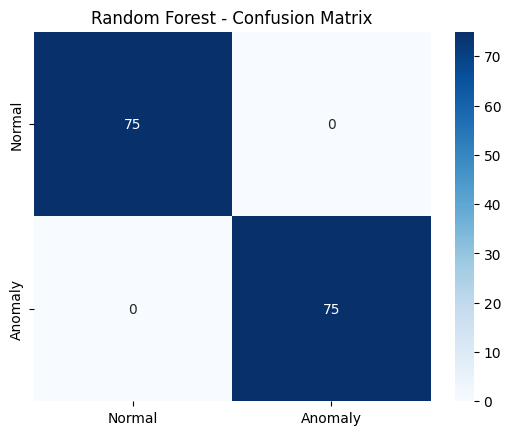


🔍 Isolation Forest Results:
              precision    recall  f1-score   support

      Normal       0.67      0.60      0.63        75
     Anomaly       0.64      0.71      0.67        75

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150



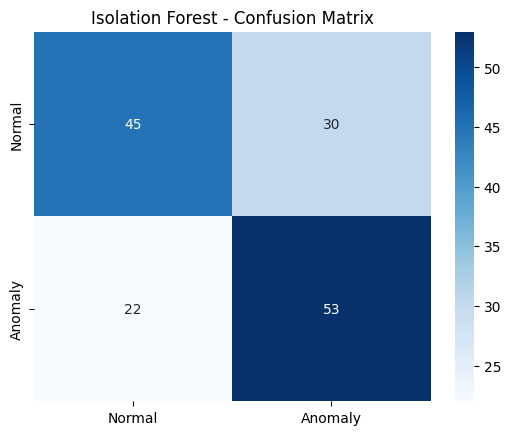

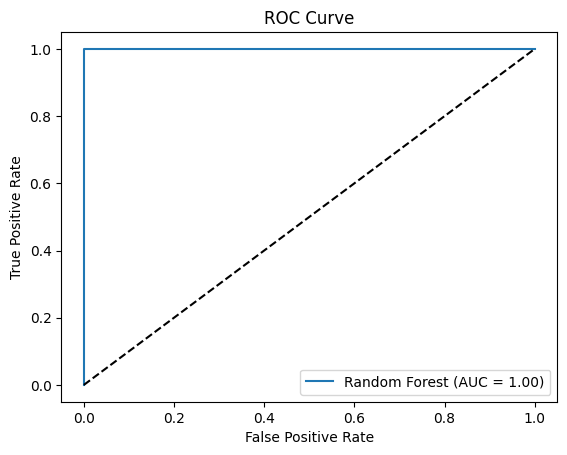

In [2]:
# 📌 Step 1: Install dependencies (if not already installed)
!pip install scikit-learn matplotlib seaborn pandas

# 📌 Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# 📌 Step 3: Load dataset (Upload merged_logs.csv or mount Google Drive)
from google.colab import files
uploaded = files.upload()   # 👈 Upload merged_logs.csv here

df = pd.read_csv("merged_logs.csv")
print("Dataset shape:", df.shape)
display(df.head())

# 📌 Step 4: Preprocessing
# Drop timestamp since it's not useful for ML
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numerical columns (e.g., fill with 0 or mean)
for col in num_cols:
    df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()

# Handle missing values in categorical columns (e.g., fill with "missing")
for col in cat_cols:
    df[col].fillna("missing", inplace=True)

# Encode categorical columns
# cat_cols.remove("label")  # Exclude target column if it's in cat_cols
if "label" in cat_cols:
  cat_cols.remove("label")

encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
# num_cols.remove("label") if "label" in num_cols else None # Exclude target column if it's in num_cols
if "label" in num_cols:
  num_cols.remove("label")

df[num_cols] = scaler.fit_transform(df[num_cols])


# Split features & labels
X = df.drop(columns=["label"])
y = df["label"].map({"normal": 0, "anomaly": 1})  # 0 = normal, 1 = anomaly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 📌 Step 5: Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 📌 Step 6: Train Isolation Forest (unsupervised)
iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train)
iso_preds = iso.predict(X_test)

# Convert Isolation Forest output: {1: normal, -1: anomaly}
iso_preds = np.where(iso_preds == 1, 0, 1)

# 📌 Step 7: Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Results:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Evaluate both models
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("Isolation Forest", y_test, iso_preds)

# 📌 Step 8: ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

Saving merged_logs.csv to merged_logs (4).csv
Dataset shape: (500, 33)


/tmp/ipython-input-1366452512.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()
/tmp/ipython-input-1366452512.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 


🔍 Random Forest Results:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        75
     Anomaly       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



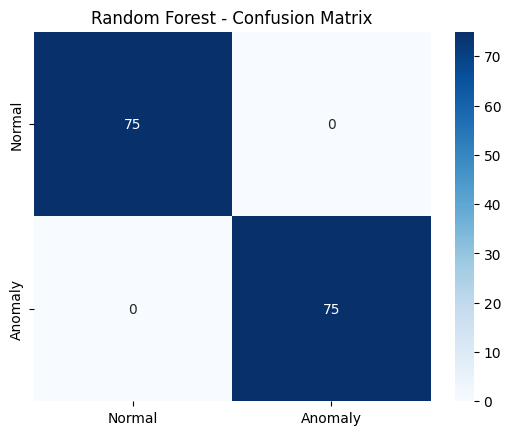


🔍 Isolation Forest Results:
              precision    recall  f1-score   support

      Normal       0.67      0.60      0.63        75
     Anomaly       0.64      0.71      0.67        75

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150



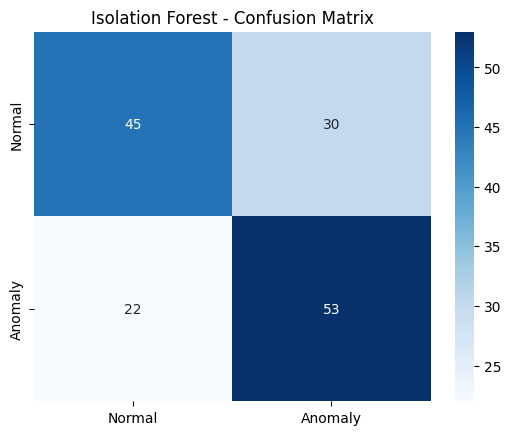

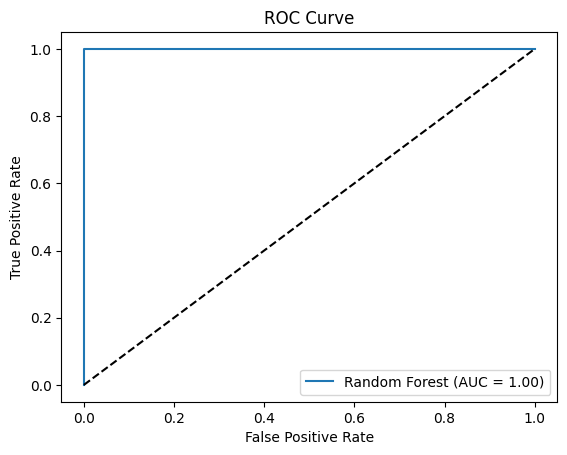


📊 Model Performance Summary:

              Model  Accuracy  Precision    Recall  F1-score
0     Random Forest  1.000000   1.000000  1.000000  1.000000
1  Isolation Forest  0.653333   0.638554  0.706667  0.670886


In [4]:
# 📌 Step 1: Install dependencies (if not already installed)
!pip install scikit-learn matplotlib seaborn pandas

# 📌 Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# 📌 Step 3: Load dataset (Upload merged_logs.csv or mount Google Drive)
from google.colab import files
uploaded = files.upload()   # 👈 Upload merged_logs.csv here

df = pd.read_csv("merged_logs.csv")
print("Dataset shape:", df.shape)
df.head()

# 📌 Step 4: Preprocessing
# Drop timestamp since it's not useful for ML
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numerical columns (e.g., fill with 0 or mean)
for col in num_cols:
    df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()

# Handle missing values in categorical columns (e.g., fill with "missing")
for col in cat_cols:
    df[col].fillna("missing", inplace=True)

# Encode categorical columns
# cat_cols.remove("label")  # Exclude target column if it's in cat_cols
if "label" in cat_cols:
  cat_cols.remove("label")


encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "label" in num_cols:
    num_cols.remove("label")
df[num_cols] = scaler.fit_transform(df[num_cols])

# Split features & labels
X = df.drop(columns=["label"])
y = df["label"].map({"normal": 0, "anomaly": 1})  # 0 = normal, 1 = anomaly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 📌 Step 5: Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 📌 Step 6: Train Isolation Forest (unsupervised)
iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train)
iso_preds = iso.predict(X_test)

# Convert Isolation Forest output: {1: normal, -1: anomaly}
iso_preds = np.where(iso_preds == 1, 0, 1)

# 📌 Step 7: Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Results:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Evaluate both models
rf_results = evaluate_model("Random Forest", y_test, rf_preds)
iso_results = evaluate_model("Isolation Forest", y_test, iso_preds)

# 📌 Step 8: ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 📌 Step 9: Summary Table
summary_df = pd.DataFrame([rf_results, iso_results])
print("\n📊 Model Performance Summary:\n")
print(summary_df)

Saving merged_logs.csv to merged_logs (6).csv
Dataset shape: (500, 33)


/tmp/ipython-input-385056653.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()
/tmp/ipython-input-385056653.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd


🔍 Random Forest Results:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        75
     Anomaly       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



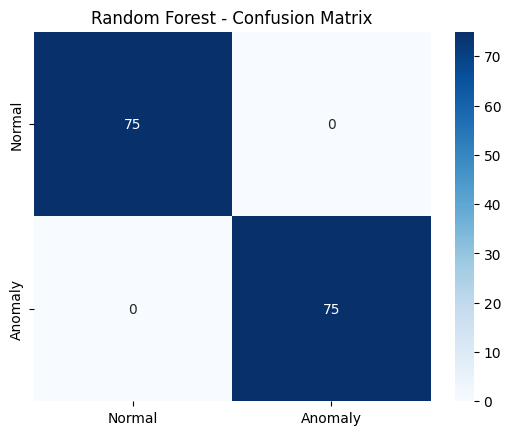


🔍 Isolation Forest Results:
              precision    recall  f1-score   support

      Normal       0.67      0.60      0.63        75
     Anomaly       0.64      0.71      0.67        75

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150



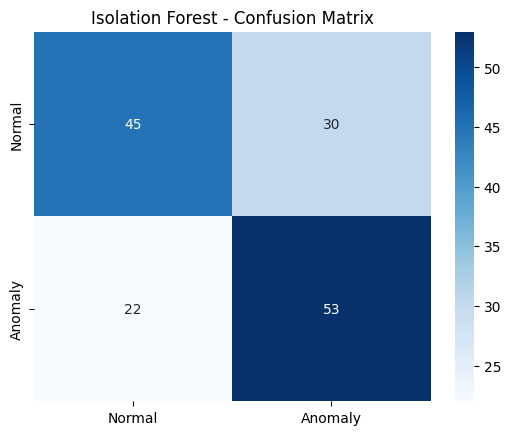

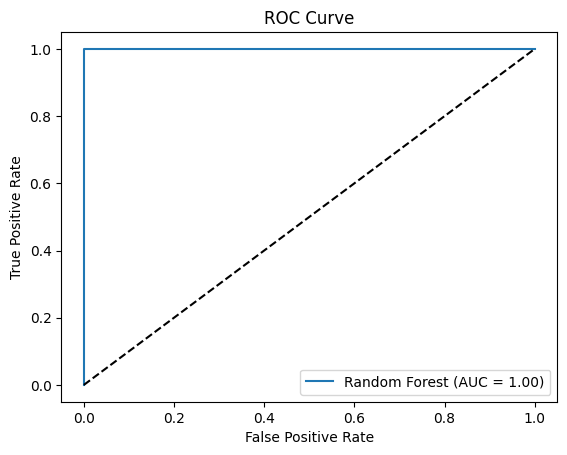


📊 Model Performance Summary:

              Model  Accuracy  Precision    Recall  F1-score
0     Random Forest  1.000000   1.000000  1.000000  1.000000
1  Isolation Forest  0.653333   0.638554  0.706667  0.670886


/tmp/ipython-input-385056653.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


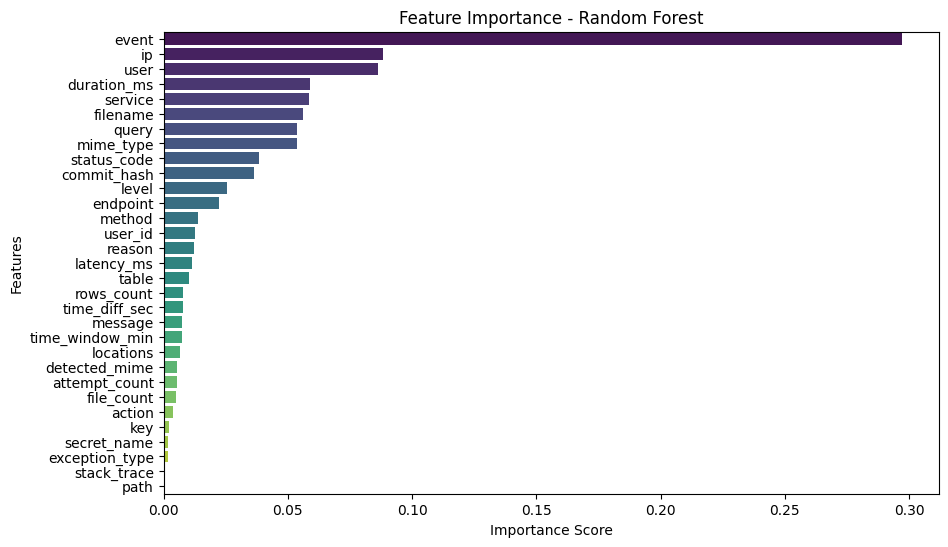

In [6]:
# 📌 Step 1: Install dependencies (if not already installed)
!pip install scikit-learn matplotlib seaborn pandas

# 📌 Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# 📌 Step 3: Load dataset (Upload merged_logs.csv or mount Google Drive)
from google.colab import files
uploaded = files.upload()   # 👈 Upload merged_logs.csv here

df = pd.read_csv("merged_logs.csv")
print("Dataset shape:", df.shape)
df.head()

# 📌 Step 4: Preprocessing
# Drop timestamp since it's not useful for ML
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numerical columns (e.g., fill with 0 or mean)
for col in num_cols:
    df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()

# Handle missing values in categorical columns (e.g., fill with "missing")
for col in cat_cols:
    df[col].fillna("missing", inplace=True)

# Encode categorical columns
# cat_cols.remove("label")  # Exclude target column if it's in cat_cols
if "label" in cat_cols:
  cat_cols.remove("label")

encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "label" in num_cols:
    num_cols.remove("label")
df[num_cols] = scaler.fit_transform(df[num_cols])

# Split features & labels
X = df.drop(columns=["label"])
y = df["label"].map({"normal": 0, "anomaly": 1})  # 0 = normal, 1 = anomaly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 📌 Step 5: Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 📌 Step 6: Train Isolation Forest (unsupervised)
iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train)
iso_preds = iso.predict(X_test)

# Convert Isolation Forest output: {1: normal, -1: anomaly}
iso_preds = np.where(iso_preds == 1, 0, 1)

# 📌 Step 7: Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Results:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Evaluate both models
rf_results = evaluate_model("Random Forest", y_test, rf_preds)
iso_results = evaluate_model("Isolation Forest", y_test, iso_preds)

# 📌 Step 8: ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 📌 Step 9: Summary Table
summary_df = pd.DataFrame([rf_results, iso_results])
print("\n📊 Model Performance Summary:\n")
print(summary_df)

# 📌 Step 10: Feature Importance (Random Forest)
importances = rf.feature_importances_
features = X.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

Saving merged_logs.csv to merged_logs (8).csv
Dataset shape: (500, 33)


/tmp/ipython-input-3431772443.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()
/tmp/ipython-input-3431772443.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 


🔍 Random Forest Results:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        75
     Anomaly       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



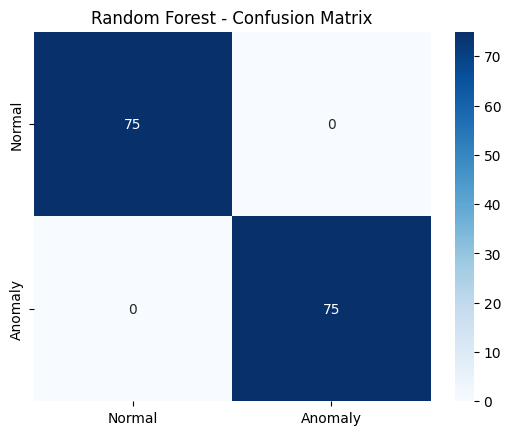


🔍 Isolation Forest Results:
              precision    recall  f1-score   support

      Normal       0.67      0.60      0.63        75
     Anomaly       0.64      0.71      0.67        75

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150



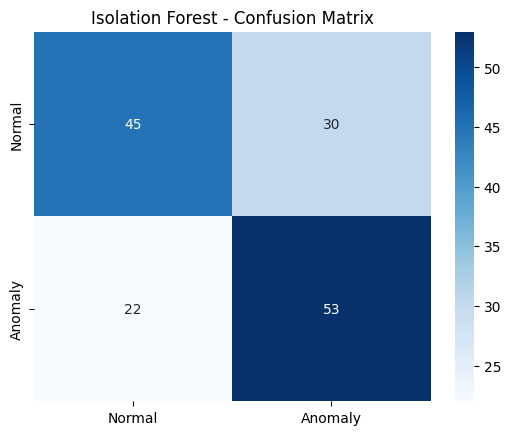

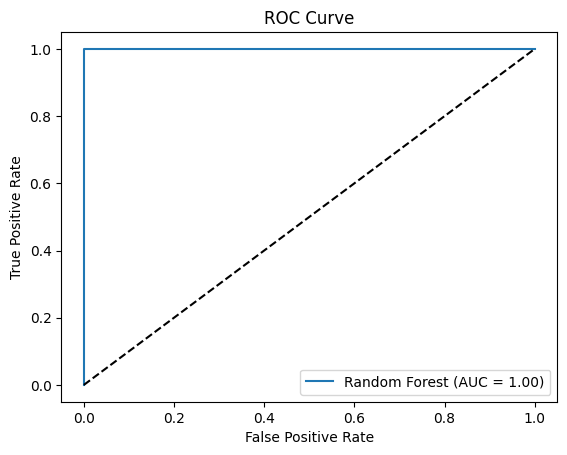


📊 Model Performance Summary:

              Model  Accuracy  Precision    Recall  F1-score
0     Random Forest  1.000000   1.000000  1.000000  1.000000
1  Isolation Forest  0.653333   0.638554  0.706667  0.670886


/tmp/ipython-input-3431772443.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


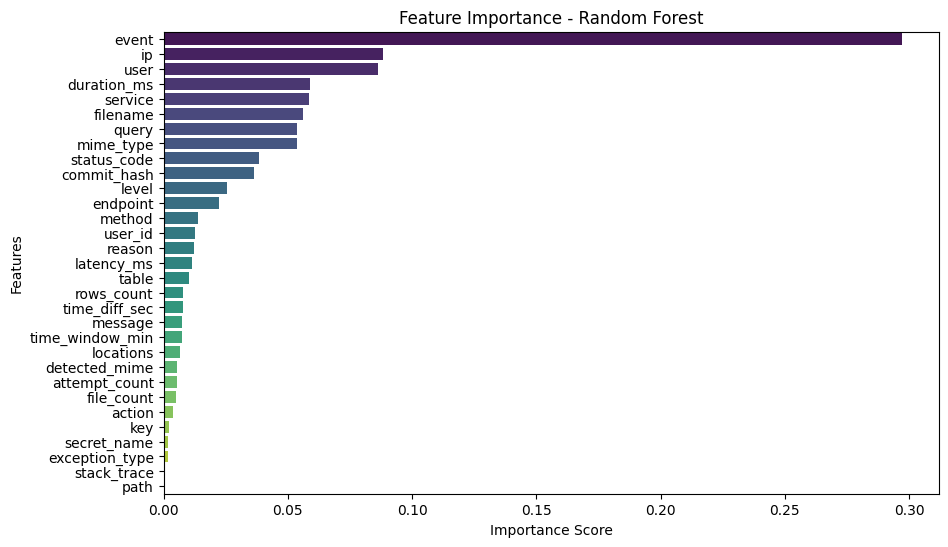


📌 Cross-validation (5-fold) F1-scores: [1. 1. 1. 1. 1.]
Mean F1-score: 1.0


In [8]:
# 📌 Step 1: Install dependencies (if not already installed)
!pip install scikit-learn matplotlib seaborn pandas

# 📌 Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# 📌 Step 3: Load dataset (Upload merged_logs.csv or mount Google Drive)
from google.colab import files
uploaded = files.upload()   # 👈 Upload merged_logs.csv here

df = pd.read_csv("merged_logs.csv")
print("Dataset shape:", df.shape)
df.head()

# 📌 Step 4: Preprocessing
# Drop timestamp since it's not useful for ML
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numerical columns (e.g., fill with 0 or mean)
for col in num_cols:
    df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()

# Handle missing values in categorical columns (e.g., fill with "missing")
for col in cat_cols:
    df[col].fillna("missing", inplace=True)

# Encode categorical columns
# cat_cols.remove("label")  # Exclude target column if it's in cat_cols
if "label" in cat_cols:
  cat_cols.remove("label")

encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "label" in num_cols:
    num_cols.remove("label")
df[num_cols] = scaler.fit_transform(df[num_cols])

# Split features & labels
X = df.drop(columns=["label"])
y = df["label"].map({"normal": 0, "anomaly": 1})  # 0 = normal, 1 = anomaly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 📌 Step 5: Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 📌 Step 6: Train Isolation Forest (unsupervised)
iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train)
iso_preds = iso.predict(X_test)

# Convert Isolation Forest output: {1: normal, -1: anomaly}
iso_preds = np.where(iso_preds == 1, 0, 1)

# 📌 Step 7: Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Results:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Evaluate both models
rf_results = evaluate_model("Random Forest", y_test, rf_preds)
iso_results = evaluate_model("Isolation Forest", y_test, iso_preds)

# 📌 Step 8: ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 📌 Step 9: Summary Table
summary_df = pd.DataFrame([rf_results, iso_results])
print("\n📊 Model Performance Summary:\n")
print(summary_df)

# 📌 Step 10: Feature Importance (Random Forest)
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# 📌 Step 11: Cross-validation for Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring="f1")

print("\n📌 Cross-validation (5-fold) F1-scores:", cv_scores)
print("Mean F1-score:", np.mean(cv_scores))

Saving merged_logs.csv to merged_logs (10).csv
Dataset shape: (500, 33)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/tmp/ipython-input-1416276282.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()
/tmp/ipython-input-1416276282.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 


✅ Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🔍 Random Forest (Tuned) Results:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        75
     Anomaly       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



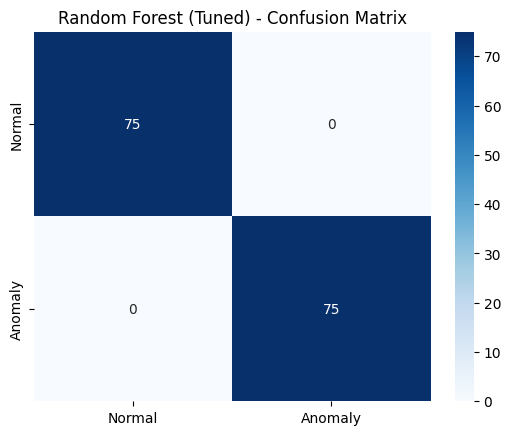


🔍 Isolation Forest Results:
              precision    recall  f1-score   support

      Normal       0.67      0.60      0.63        75
     Anomaly       0.64      0.71      0.67        75

    accuracy                           0.65       150
   macro avg       0.66      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150



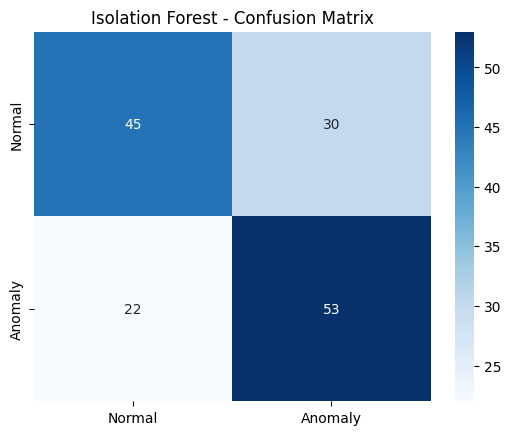

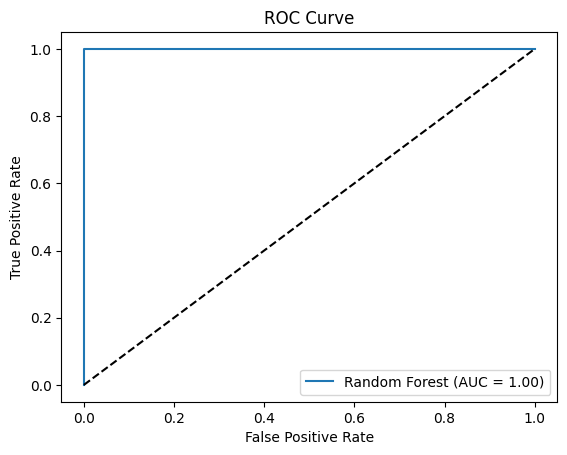


📊 Model Performance Summary:

                   Model  Accuracy  Precision    Recall  F1-score
0  Random Forest (Tuned)  1.000000   1.000000  1.000000  1.000000
1       Isolation Forest  0.653333   0.638554  0.706667  0.670886


/tmp/ipython-input-1416276282.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


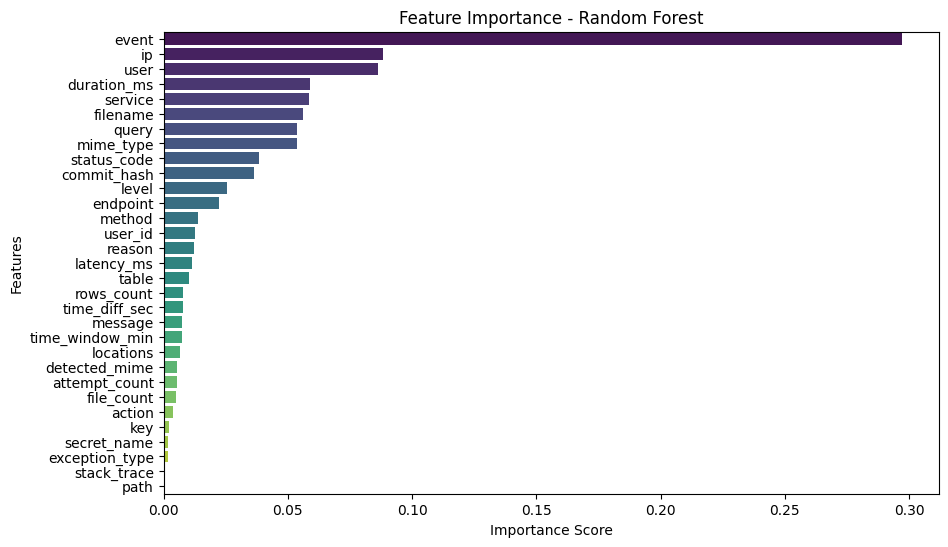


📌 Cross-validation (5-fold) F1-scores: [1. 1. 1. 1. 1.]
Mean F1-score: 1.0


In [10]:
# 📌 Step 1: Install dependencies (if not already installed)
!pip install scikit-learn matplotlib seaborn pandas

# 📌 Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

# 📌 Step 3: Load dataset (Upload merged_logs.csv or mount Google Drive)
from google.colab import files
uploaded = files.upload()   # 👈 Upload merged_logs.csv here

df = pd.read_csv("merged_logs.csv")
print("Dataset shape:", df.shape)
df.head()

# 📌 Step 4: Preprocessing
# Drop timestamp since it's not useful for ML
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numerical columns (e.g., fill with 0 or mean)
for col in num_cols:
    df[col].fillna(0, inplace=True) # You can replace 0 with df[col].mean() or df[col].median()

# Handle missing values in categorical columns (e.g., fill with "missing")
for col in cat_cols:
    df[col].fillna("missing", inplace=True)

# Encode categorical columns
# cat_cols.remove("label")  # Exclude target column if it's in cat_cols
if "label" in cat_cols:
  cat_cols.remove("label")

encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "label" in num_cols:
    num_cols.remove("label")
df[num_cols] = scaler.fit_transform(df[num_cols])

# Split features & labels
X = df.drop(columns=["label"])
y = df["label"].map({"normal": 0, "anomaly": 1})  # 0 = normal, 1 = anomaly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 📌 Step 5: Hyperparameter tuning for Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("\n✅ Best Random Forest Params:", grid_search.best_params_)

# Train best RF model
rf = grid_search.best_estimator_
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 📌 Step 6: Train Isolation Forest (unsupervised)
iso = IsolationForest(contamination=0.5, random_state=42)
iso.fit(X_train)
iso_preds = iso.predict(X_test)
iso_preds = np.where(iso_preds == 1, 0, 1)  # Convert {1=normal, -1=anomaly}

# 📌 Step 7: Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Results:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Evaluate both models
rf_results = evaluate_model("Random Forest (Tuned)", y_test, rf_preds)
iso_results = evaluate_model("Isolation Forest", y_test, iso_preds)

# 📌 Step 8: ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 📌 Step 9: Summary Table
summary_df = pd.DataFrame([rf_results, iso_results])
print("\n📊 Model Performance Summary:\n")
print(summary_df)

# 📌 Step 10: Feature Importance (Random Forest)
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# 📌 Step 11: Cross-validation with tuned Random Forest
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring="f1")
print("\n📌 Cross-validation (5-fold) F1-scores:", cv_scores)
print("Mean F1-score:", np.mean(cv_scores))